# Trabajo integrador - Computer Vision II (CEIA)

Integrantes:

- Cecilia Azul Villanueva
- Christopher Charaf
- Diego Araujo

## Clasificación de residuos para reciclaje (TrashNet)

### Objetivo

El problema que se trata de resolver, es la clasificación de residuos para reciclaje.

Para esto, es necesario entrenar un modelo que, a partir de imágenes, clasifique distintos tipos de residuos (plástico, vidrio, papel, orgánicos) para optimizar procesos de reciclaje y gestión de residuos.​

### Introducción al problema

El manejo eficiente de residuos es un desafío que impacta directamente en la sostenibilidad ambiental. La clasificación manual de desechos para su reciclaje es un proceso costoso, lento y propenso a errores. Sin embargo, la inteligencia artificial, en particular la visión por computadora, podría ofrecer soluciones para optimizar esta tarea.

En este proyecto, utilizaremos modelos de aprendizaje profundo para clasificar automáticamente distintos tipos de residuos a partir de imágenes. Esto permitirá mejorar la gestión de reciclaje al agilizar la separación de materiales como plástico, vidrio, papel, metal y cartón, reduciendo la contaminación y aumentando la eficiencia en el tratamiento de residuos.

Para el entrenamiento del modelo, emplearemos el dataset [TrashNet](https://www.kaggle.com/datasets/feyzazkefe/trashnet/data), que contiene imágenes de residuos organizadas en distintas categorías:

- Plástico (482 imágenes)

- Vidrio (501 imágenes)

- Papel (594 imágenes)

- Cartón (403 imágenes)

- Metal (410 imágenes)

- Basura (137 imágenes)

Al desarrollar este sistema, buscamos no solo mejorar la clasificación de residuos, sino también explorar aplicaciones en contenedores inteligentes y sensores de clasificación automática, contribuyendo así a una economía circular más eficiente.

### Paquetes a utilizar

In [ ]:
!pip install torchmetrics

In [1]:
# Paquetes a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random

import os
import cv2 as cv

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet50
import torchsummary
import torchmetrics


from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score



### Carga de Datos

Empezamos cargando las imágenes del dataset.

In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

# Verificamos que dataset_path exista
if not os.path.exists(path):
    print("Ruta no encontrada:", path)
else:

    subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    if not subdirs:
        print("No se encontraron subcarpetas dentro de:", path)
    else:
        print("Directorio Encontrado!")
        dataset_path = os.path.join(path, subdirs[0])
        print("Usando carpeta:", dataset_path)

        # Obtenemos las categorías (subcarpetas dentro de dataset_dir)
        categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
        print("Categorías de residuos:", categories)


Directorio Encontrado!
Usando carpeta: /kaggle/input/trashnet/dataset-resized
Categorías de residuos: ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


Ahora veremos que tipo de imagen tiene cada categoría antes definida.

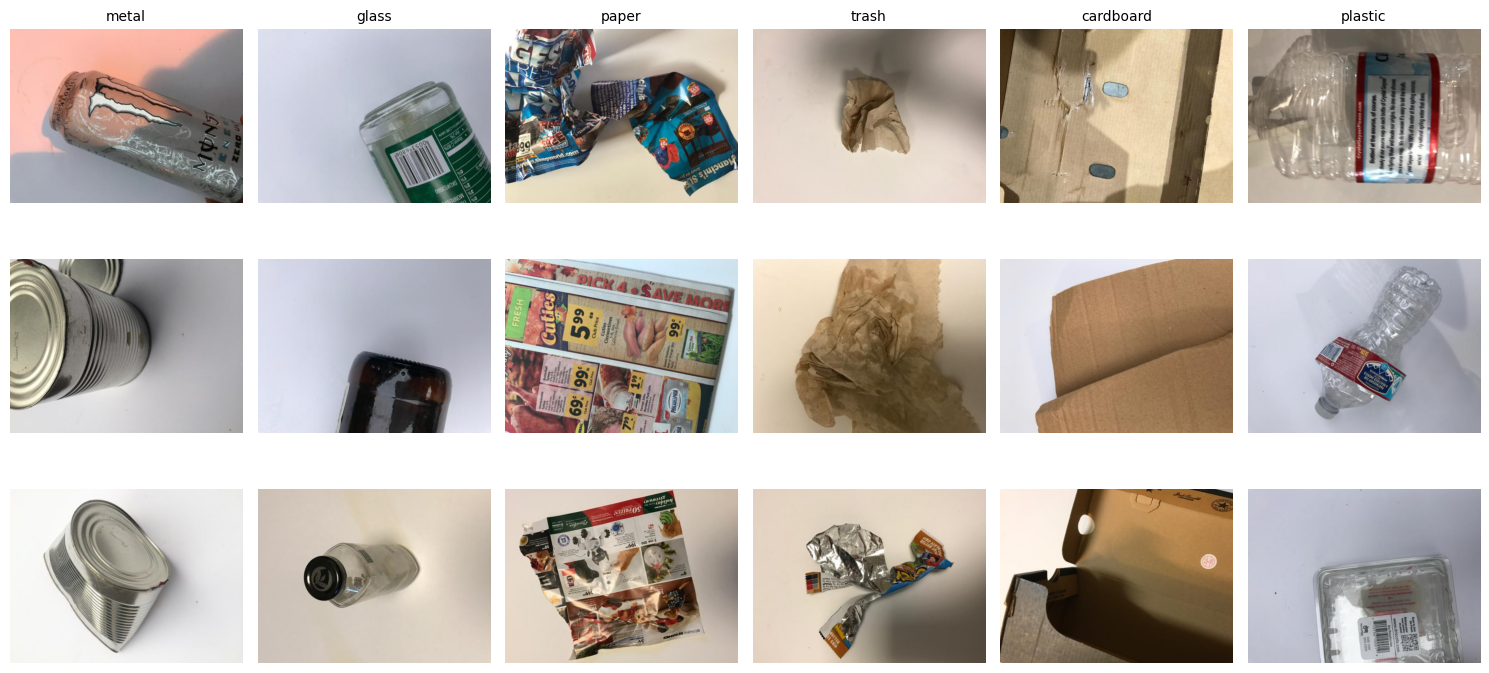

In [23]:
# Cantidad de imágenes
n_images = 3

# Categorías desde las carpetas
#categories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
n_categories = len(categories)

# Visualización
fig, axes = plt.subplots(n_images, n_categories, figsize=(n_categories * 2.5, n_images * 2.5))

if n_images == 1:
    axes = [axes]
if n_categories == 1:
    axes = [[ax] for ax in axes]

for col_idx, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.seed(123)
    selected_images = random.sample(image_files, min(n_images, len(image_files)))

    for row_idx in range(n_images):
        ax = axes[row_idx][col_idx]
        ax.axis("off")

        if row_idx < len(selected_images):
            image_path = os.path.join(category_path, selected_images[row_idx])
            img = mpimg.imread(image_path)
            ax.imshow(img)

        if row_idx == 0:
            ax.set_title(category, fontsize=10)

plt.tight_layout()
plt.show()

Analizando las imágenes que hay dentro de cada carpeta, se extraen patrones que definen a cada clase:

- **Glass (vidrio)**: las imágenes por lo general muestran fragmentos o botellas de vidrio, ya sean transparentes u opacos (de color), con brillos. La forma y textura pueden variar bastante, esto genera un desafío para la clasificación automática si no se entrena correctamente el modelo.

- **Cardboard (cartón)**: se presentan superficies planas y marrones mayormente (algunas en blanco) con textura rugosa o con impresiones (por ej. códigos de barras) y/o letras . Estas características son bastante particulares y podrían facilitar la detección por parte del modelo.

- **Metal**: por lo general hace referencia a imágenes de aluminio, ya sean latas o papel. Con respecto a las latas (el objeto más común), hay variedad de formas, pudiendo estar aplastadas o enteras. Los reflejos metálicos, el color plateado y detalles como el *abridor* pueden ser buenos indicadores visuales para el modelo.

- **Trash (residuos genéricos)**: esta categoría parece ser la más heterogénea y menos estructurada visualmente. Esto sugiere que puede ser una de las clases más difíciles de distinguir, pudiendo confundirse con cualquiera de las otras categorías.

- **Paper (papel)**: aparecen principalmente hojas impresas, en algunos casos arrugadas, con colores e impresiones variadas. A diferencia del cartón, el papel tiende a ser más delgado, con mayor paleta de colores y mayor variación en el contenido gráfico.

- **Plastic (plástico)**: se observan botellas o envases típicos, en su mayoría con etiquetas impresas. El brillo y la forma también podrían ser claves para el modelo de clasificación.

El problema presenta 2 desafíos principales para la clasificación: uno es la poca cantidad de datos (además del desbalanceo de clases) y otro es la similitud entre algunas imágenes de las distintas categorías.

Esto último se puede ver en las siguientes imágenes:

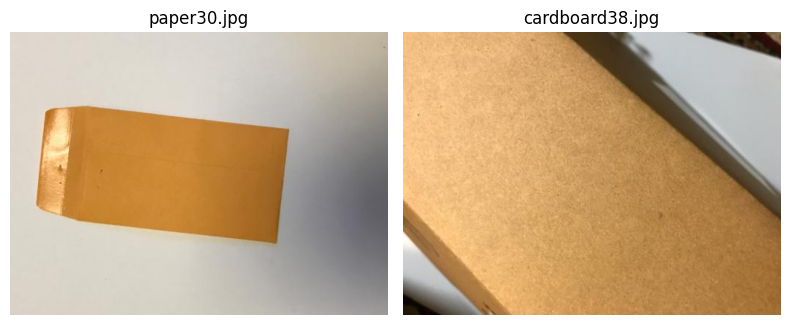

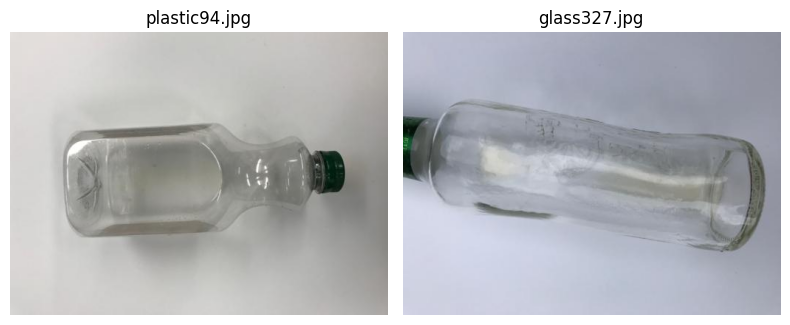

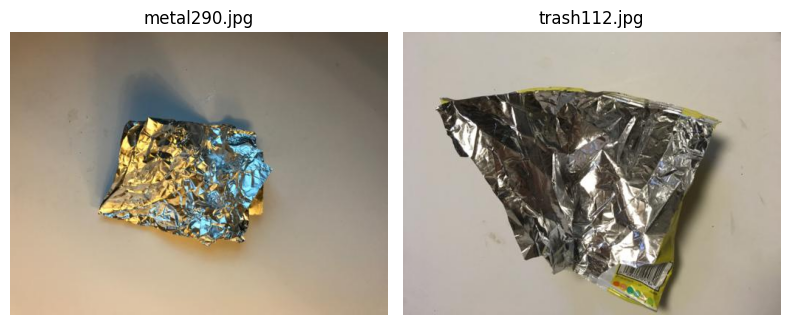

In [24]:
# Comparación de imágenes similares
image_pairs = [
    ("paper30.jpg", "cardboard38.jpg"),
    ("plastic94.jpg", "glass327.jpg"),
    ("metal290.jpg", "trash112.jpg")

]


all_image_paths = {}
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg')):
            all_image_paths[file] = os.path.join(root, file)


for img1_name, img2_name in image_pairs:

    img1 = mpimg.imread(all_image_paths[img1_name])
    img2 = mpimg.imread(all_image_paths[img2_name])

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img1)
    axes[0].set_title(img1_name)
    axes[0].axis("off")

    axes[1].imshow(img2)
    axes[1].set_title(img2_name)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [25]:
# Clase personalizada para el dataset
class WasteDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = {category: idx for idx, category in enumerate(categories)}
        self.idx_to_class = {idx: category for idx, category in enumerate(categories)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        # Obtener etiqueta desde la estructura de carpetas
        label = os.path.basename(os.path.dirname(image_path))
        label_idx = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Todas las rutas de imágenes
all_image_paths = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_paths = [os.path.join(category_path, f) for f in os.listdir(category_path)
                  if f.endswith(('.jpg', '.png', '.jpeg'))]
    all_image_paths.extend(image_paths)

# Se divide en train y validation
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42, stratify=[os.path.basename(os.path.dirname(p)) for p in all_image_paths])



### Transformaciones de Datos

Tamaño del batch de imágenes: torch.Size([32, 3, 224, 224])
Tamaño del batch de etiquetas: torch.Size([32])


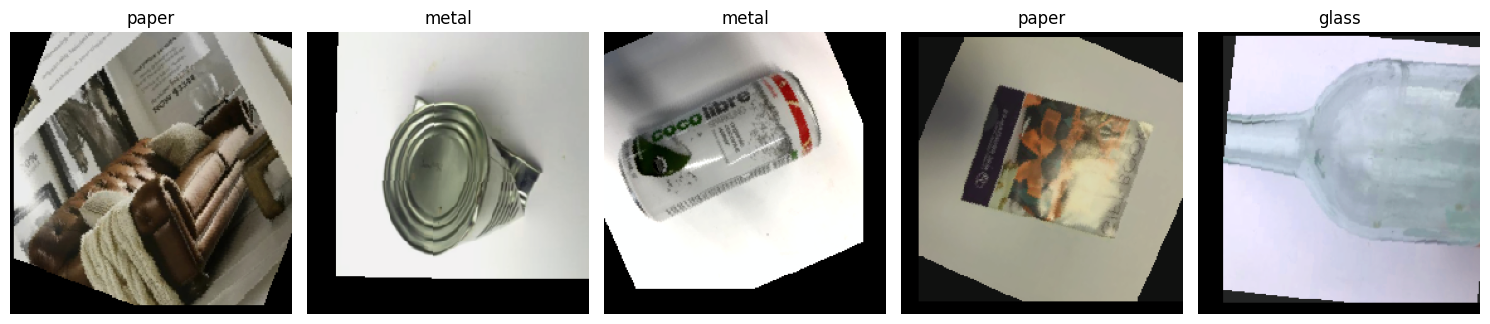

In [ ]:
# Transformaciones de datos

# Data augmentation para training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaciones básicas para validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creación de datasets y dataloaders
train_dataset = WasteDataset(train_paths, transform=train_transform)
val_dataset = WasteDataset(val_paths, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Vemos una muestra, a ver como quedó
images, labels = next(iter(train_loader))
print(f"Tamaño del batch de imágenes: {images.shape}")
print(f"Tamaño del batch de etiquetas: {labels.shape}")

# Visualización de algunas imágenes con data augmentation
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Muestra de algunas imágenes de entrenamiento con data augmentation
plt.figure(figsize=(15, 5))
for i in range(min(5, batch_size)):
    plt.subplot(1, 5, i+1)
    imshow(images[i], train_dataset.idx_to_class[labels[i].item()])
plt.tight_layout()
plt.show()

# Función para entrenar y evaluar modelos
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name='model'):
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Cada epoch tiene una fase de entrenamiento y una de validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterar sobre los datos
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

                if scheduler:
                    scheduler.step(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), f'{model_name}_best.pth')

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history,
        'best_acc': best_acc
    }

    return history

# Función para evaluar el modelo y mostrar métricas
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap = "rocket_r", fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Predicción')
    plt.show()

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # ROC AUC (para multiclase)
    try:
        roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        print(f"\nROC AUC Score: {roc_auc:.4f}")
    except:
        print("\nNo se pudo calcular ROC AUC para multiclase")

    return all_preds, all_labels, all_probs

# Función para graficar historial de entrenamiento
def plot_training_history(history, model_name):
    plt.figure(figsize=(7, 5))

    # Gráfico de pérdida
    plt.subplot(2, 1, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Pérdida durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Gráfico de exactitud
    plt.subplot(2, 1, 2)
    plt.plot([acc.cpu().numpy() for acc in history['train_acc']], label='Train Acc')
    plt.plot([acc.cpu().numpy() for acc in history['val_acc']], label='Val Acc')
    plt.title(f'{model_name} - Exactitud durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [ ]:
# Configuración de dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cuda:0


### Modelo 1: CNN


---- Entrenamiento 1: CNN básica sin aumentos ----
Epoch 0/19
----------
train Loss: 1.7234 Acc: 0.2820
val Loss: 1.4508 Acc: 0.3953

Epoch 1/19
----------
train Loss: 1.4396 Acc: 0.4191
val Loss: 1.3645 Acc: 0.4348

Epoch 2/19
----------
train Loss: 1.3466 Acc: 0.4488
val Loss: 1.3253 Acc: 0.4881

Epoch 3/19
----------
train Loss: 1.3285 Acc: 0.4557
val Loss: 1.1787 Acc: 0.5771

Epoch 4/19
----------
train Loss: 1.2139 Acc: 0.5225
val Loss: 1.1755 Acc: 0.5514

Epoch 5/19
----------
train Loss: 1.2254 Acc: 0.5344
val Loss: 1.0923 Acc: 0.5988

Epoch 6/19
----------
train Loss: 1.1805 Acc: 0.5369
val Loss: 1.1034 Acc: 0.5652

Epoch 7/19
----------
train Loss: 1.1824 Acc: 0.5349
val Loss: 1.0706 Acc: 0.6364

Epoch 8/19
----------
train Loss: 1.1346 Acc: 0.5591
val Loss: 1.0434 Acc: 0.6166

Epoch 9/19
----------
train Loss: 1.1173 Acc: 0.5809
val Loss: 1.0508 Acc: 0.6107

Epoch 10/19
----------
train Loss: 1.1025 Acc: 0.5834
val Loss: 0.9898 Acc: 0.6364

Epoch 11/19
----------
train Loss:

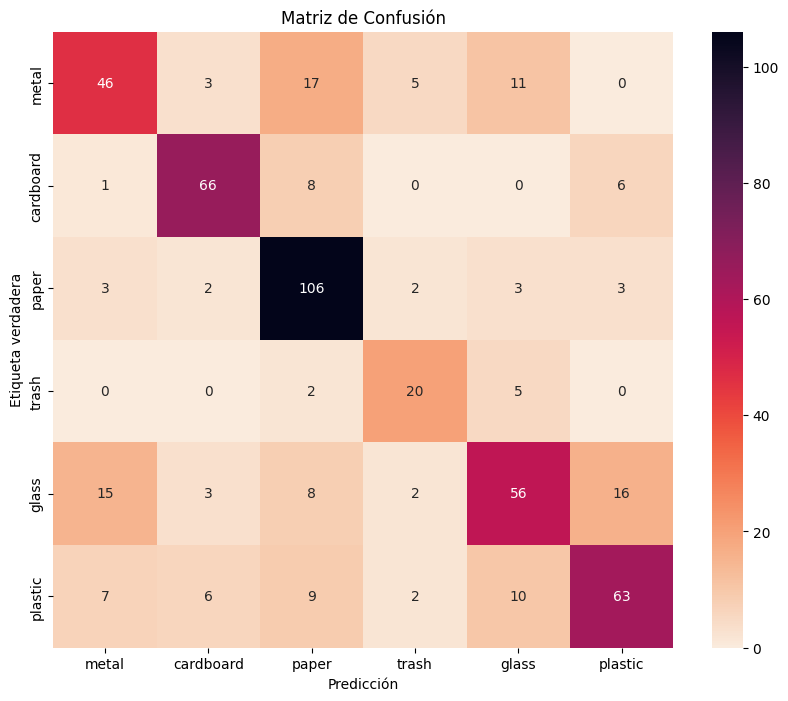


Reporte de Clasificación:
              precision    recall  f1-score   support

       metal       0.64      0.56      0.60        82
   cardboard       0.82      0.81      0.82        81
       paper       0.71      0.89      0.79       119
       trash       0.65      0.74      0.69        27
       glass       0.66      0.56      0.61       100
     plastic       0.72      0.65      0.68        97

    accuracy                           0.71       506
   macro avg       0.70      0.70      0.70       506
weighted avg       0.70      0.71      0.70       506


ROC AUC Score: 0.9344


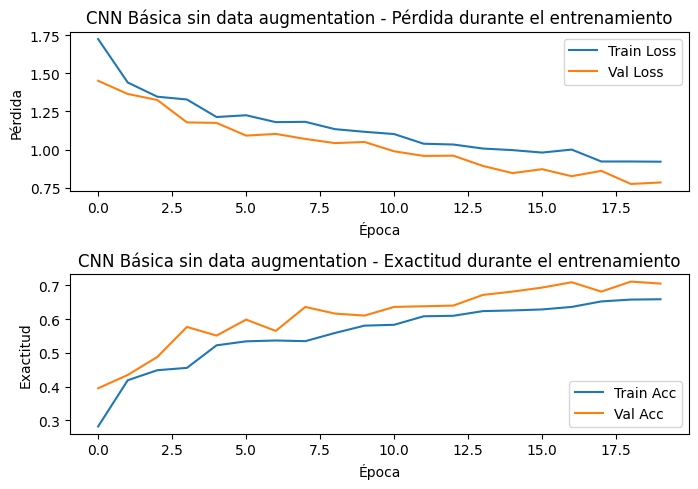

In [ ]:
## Modelo 1: CNN personalizada

class WasteCNN(torch.nn.Module):
    def __init__(self, num_classes=6):
        super(WasteCNN, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(256 * 14 * 14, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Entrenamiento 1: CNN básica sin aumentos
print("\n---- Entrenamiento 1: CNN básica sin aumentos ----")

# Se usan transformaciones básicas (sin aumentos) para comparación
train_dataset_basic = WasteDataset(train_paths, transform=val_transform)
train_loader_basic = DataLoader(train_dataset_basic, batch_size=batch_size, shuffle=True, num_workers=2)

model_cnn_basic = WasteCNN(num_classes=len(categories)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model_cnn_basic.parameters(), lr=0.001)

# Entrenamiento del modelo
history_cnn_basic = train_model(
    model_cnn_basic,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=20,
    model_name='cnn_basic'
)

# Evaluación el modelo
print("\nEvaluación del modelo CNN básico:")
_, _, _ = evaluate_model(model_cnn_basic, val_loader, categories)

# Gráfica historial de entrenamiento
plot_training_history(history_cnn_basic, "CNN Básica sin data augmentation")



### Modelo 2: CNN con Data Augmentation


---- Entrenamiento 2: CNN con data augmentation ----
Epoch 0/19
----------
train Loss: 1.6968 Acc: 0.2905
val Loss: 1.5264 Acc: 0.3854

Epoch 1/19
----------
train Loss: 1.4895 Acc: 0.3622
val Loss: 1.3486 Acc: 0.4704

Epoch 2/19
----------
train Loss: 1.3803 Acc: 0.4523
val Loss: 1.2887 Acc: 0.5040

Epoch 3/19
----------
train Loss: 1.3143 Acc: 0.4884
val Loss: 1.2355 Acc: 0.4901

Epoch 4/19
----------
train Loss: 1.2699 Acc: 0.5072
val Loss: 1.1768 Acc: 0.5613

Epoch 5/19
----------
train Loss: 1.2338 Acc: 0.5225
val Loss: 1.0908 Acc: 0.5870

Epoch 6/19
----------
train Loss: 1.2113 Acc: 0.5393
val Loss: 1.1070 Acc: 0.6166

Epoch 7/19
----------
train Loss: 1.1993 Acc: 0.5255
val Loss: 1.1951 Acc: 0.5178

Epoch 8/19
----------
train Loss: 1.1707 Acc: 0.5507
val Loss: 1.0565 Acc: 0.6028

Epoch 9/19
----------
train Loss: 1.1075 Acc: 0.5725
val Loss: 1.0066 Acc: 0.6245

Epoch 10/19
----------
train Loss: 1.0848 Acc: 0.5804
val Loss: 1.0226 Acc: 0.6324

Epoch 11/19
----------
train Los

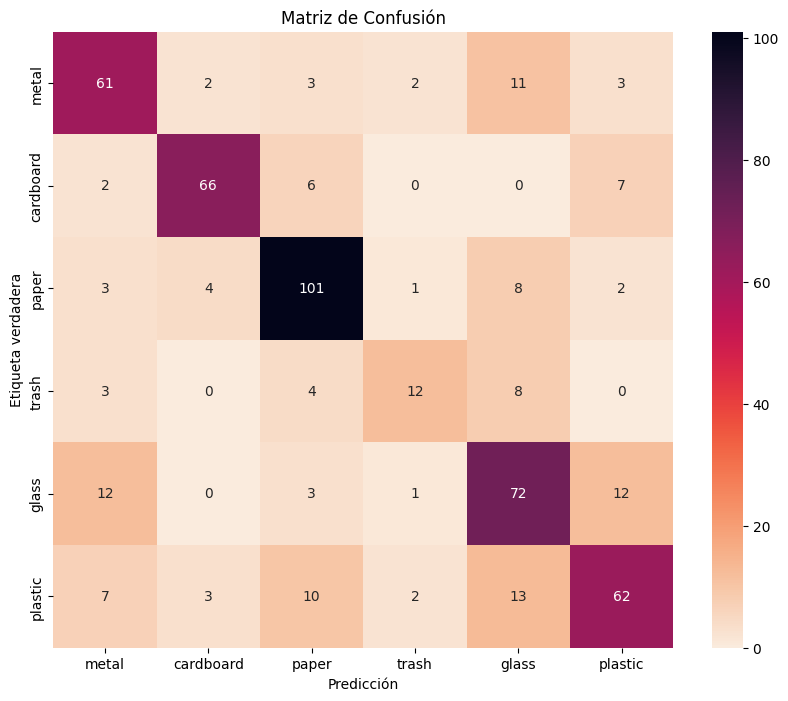


Reporte de Clasificación:
              precision    recall  f1-score   support

       metal       0.69      0.74      0.72        82
   cardboard       0.88      0.81      0.85        81
       paper       0.80      0.85      0.82       119
       trash       0.67      0.44      0.53        27
       glass       0.64      0.72      0.68       100
     plastic       0.72      0.64      0.68        97

    accuracy                           0.74       506
   macro avg       0.73      0.70      0.71       506
weighted avg       0.74      0.74      0.74       506


ROC AUC Score: 0.9402


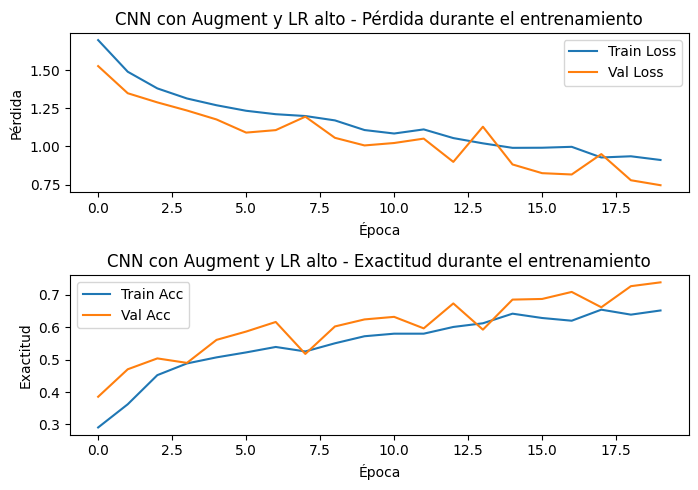

In [ ]:
# Entrenamiento 2: CNN con aumentos
print("\n---- Entrenamiento 2: CNN con data augmentation ----")

model_cnn_aug = WasteCNN(num_classes=len(categories)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model_cnn_aug.parameters(), lr=0.001)  # Ajuste en LR

# Entrenamiento del modelo con augmentation
history_cnn_aug = train_model(
    model_cnn_aug,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=20,
    model_name='cnn_aug'
)

# Evaluación del modelo
print("\nEvaluación del modelo CNN con aumentos:")
_, _, _ = evaluate_model(model_cnn_aug, val_loader, categories)

# Gráfica  historial de entrenamiento
plot_training_history(history_cnn_aug, "CNN con Augment")



### Modelo 3: ResNet50 - Fine-Tuning Parcial

In [ ]:
## Modelo 3: ResNet50 con Transfer Learning
def create_resnet_model(num_classes=6, freeze_features=True):

    model = resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

    if freeze_features:
        # Congela todos los parámetros de la red
        for param in model.parameters():
            param.requires_grad = False

    # Reemplaza la última capa fully connected
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(num_ftrs, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(512, num_classes)
    )

    return model




---- Entrenamiento 3: ResNet50 con fine-tuning parcial ----


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s]


Epoch 0/19
----------
train Loss: 1.3109 Acc: 0.4968
val Loss: 1.0061 Acc: 0.6245

Epoch 1/19
----------
train Loss: 0.9720 Acc: 0.6492
val Loss: 0.8523 Acc: 0.7253

Epoch 2/19
----------
train Loss: 0.8728 Acc: 0.6893
val Loss: 0.7004 Acc: 0.7806

Epoch 3/19
----------
train Loss: 0.8214 Acc: 0.7115
val Loss: 0.6524 Acc: 0.7589

Epoch 4/19
----------
train Loss: 0.7680 Acc: 0.7209
val Loss: 0.5445 Acc: 0.8004

Epoch 5/19
----------
train Loss: 0.8121 Acc: 0.7135
val Loss: 0.6569 Acc: 0.7806

Epoch 6/19
----------
train Loss: 0.7588 Acc: 0.7145
val Loss: 0.6848 Acc: 0.7510

Epoch 7/19
----------
train Loss: 0.7444 Acc: 0.7279
val Loss: 0.5743 Acc: 0.7727

Epoch 8/19
----------
train Loss: 0.7689 Acc: 0.7145
val Loss: 0.6070 Acc: 0.7846

Epoch 9/19
----------
train Loss: 0.7632 Acc: 0.7244
val Loss: 0.5756 Acc: 0.7964

Epoch 10/19
----------
train Loss: 0.7188 Acc: 0.7417
val Loss: 0.6413 Acc: 0.7826

Epoch 11/19
----------
train Loss: 0.7254 Acc: 0.7333
val Loss: 0.5973 Acc: 0.7806

Ep

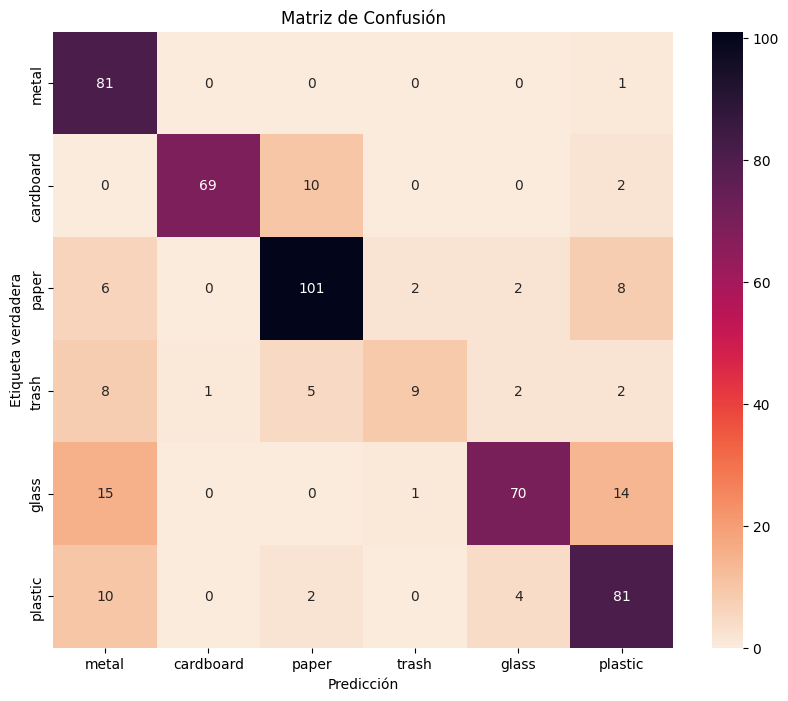


Reporte de Clasificación:
              precision    recall  f1-score   support

       metal       0.68      0.99      0.80        82
   cardboard       0.99      0.85      0.91        81
       paper       0.86      0.85      0.85       119
       trash       0.75      0.33      0.46        27
       glass       0.90      0.70      0.79       100
     plastic       0.75      0.84      0.79        97

    accuracy                           0.81       506
   macro avg       0.82      0.76      0.77       506
weighted avg       0.83      0.81      0.81       506


ROC AUC Score: 0.9748


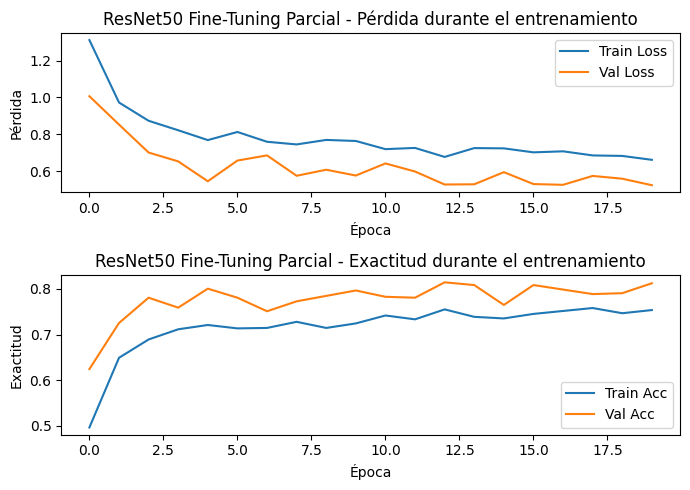

In [ ]:
# Entrenamiento 3: ResNet50 con fine-tuning parcial (capas superiores)
print("\n---- Entrenamiento 3: ResNet50 con fine-tuning parcial ----")

model_resnet_partial = create_resnet_model(num_classes=len(categories), freeze_features=True).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model_resnet_partial.parameters(), lr=0.001)

# Entrenamiento del modelo
history_resnet_partial = train_model(
    model_resnet_partial,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=20,
    model_name='resnet_partial'
)

# Evaluación del modelo
print("\nEvaluación del modelo ResNet50 con fine-tuning parcial:")
_, _, _ = evaluate_model(model_resnet_partial, val_loader, categories)

# Gráfica historial de entrenamiento
plot_training_history(history_resnet_partial, "ResNet50 Fine-Tuning Parcial")



### Modelo 4 : ResNet50 con Fine-Tuning Completo


---- Entrenamiento 4: ResNet50 con fine-tuning completo ----
Epoch 0/24
----------
train Loss: 0.9609 Acc: 0.6690
val Loss: 0.5061 Acc: 0.8103

Epoch 1/24
----------
train Loss: 0.4934 Acc: 0.8367
val Loss: 0.3252 Acc: 0.8913

Epoch 2/24
----------
train Loss: 0.3625 Acc: 0.8847
val Loss: 0.3223 Acc: 0.8893

Epoch 3/24
----------
train Loss: 0.3316 Acc: 0.8867
val Loss: 0.3014 Acc: 0.8913

Epoch 4/24
----------
train Loss: 0.2872 Acc: 0.9065
val Loss: 0.4067 Acc: 0.8696

Epoch 5/24
----------
train Loss: 0.1769 Acc: 0.9401
val Loss: 0.2195 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.1487 Acc: 0.9530
val Loss: 0.1787 Acc: 0.9387

Epoch 7/24
----------
train Loss: 0.1327 Acc: 0.9589
val Loss: 0.1655 Acc: 0.9407

Epoch 8/24
----------
train Loss: 0.1029 Acc: 0.9708
val Loss: 0.1885 Acc: 0.9328

Epoch 9/24
----------
train Loss: 0.1053 Acc: 0.9693
val Loss: 0.1911 Acc: 0.9328

Epoch 10/24
----------
train Loss: 0.0975 Acc: 0.9738
val Loss: 0.1909 Acc: 0.9387

Epoch 11/24
----------
t

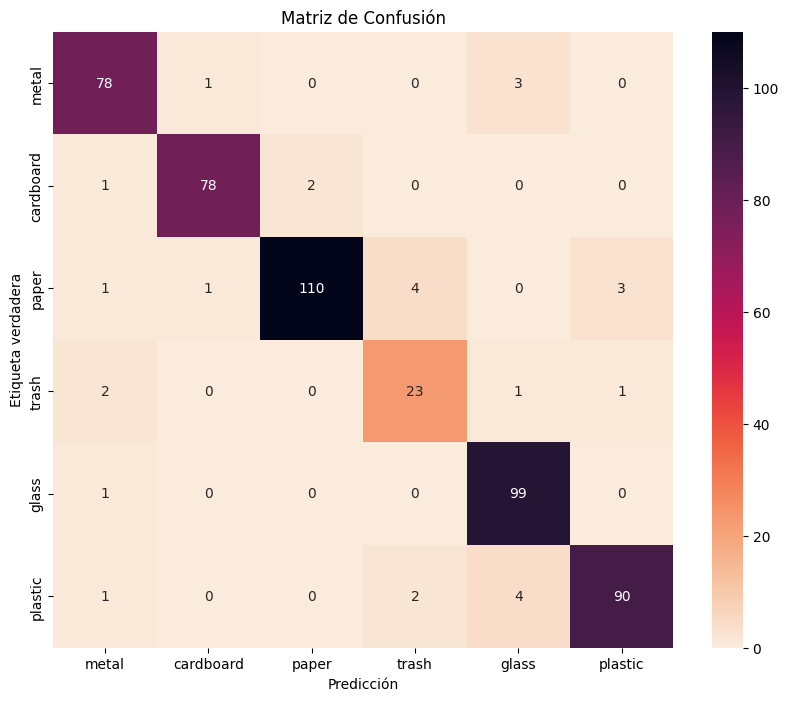


Reporte de Clasificación:
              precision    recall  f1-score   support

       metal       0.93      0.95      0.94        82
   cardboard       0.97      0.96      0.97        81
       paper       0.98      0.92      0.95       119
       trash       0.79      0.85      0.82        27
       glass       0.93      0.99      0.96       100
     plastic       0.96      0.93      0.94        97

    accuracy                           0.94       506
   macro avg       0.93      0.93      0.93       506
weighted avg       0.95      0.94      0.94       506


ROC AUC Score: 0.9969


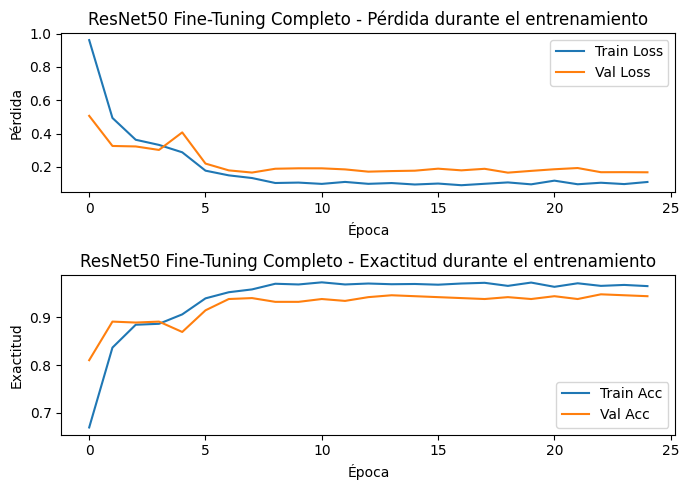

In [ ]:
# Entrenamiento 4: ResNet50 con fine-tuning completo
print("\n---- Entrenamiento 4: ResNet50 con fine-tuning completo ----")

model_resnet_full = create_resnet_model(num_classes=len(categories), freeze_features=False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model_resnet_full.parameters(), lr=0.0001)  # LR más bajo para fine-tuning completo

# Uso de scheduler para ajustar LR
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Entrenamiento del modelo
history_resnet_full = train_model(
    model_resnet_full,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,  # Más épocas para fine-tuning
    model_name='resnet_full'
)

# Evaluación del modelo
print("\nEvaluación del modelo ResNet50 con fine-tuning completo:")
_, _, _ = evaluate_model(model_resnet_full, val_loader, categories)

# Graáfica historial de entrenamiento
plot_training_history(history_resnet_full, "ResNet50 Fine-Tuning Completo")



### Comparación de Modelos

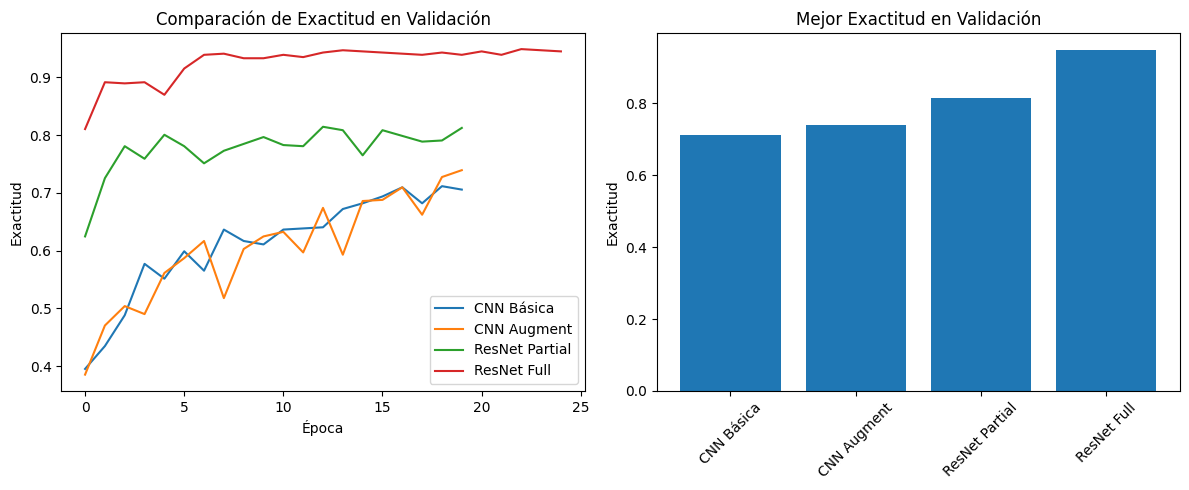


=== Conclusiones ===
1. Data Augmentation: Se implementaron transformaciones como rotaciones, volteos, ajustes de color y zoom para mejorar la generalización.
2. Métricas: Se evaluó con accuracy, precisión, recall, F1-score por clase, matriz de confusión y ROC AUC.
3. Arquitecturas: Se probaron CNN personalizada y ResNet50 con transfer learning.
4. Entrenamientos:
   - CNN básica sin aumentos: Resultados modestos, probable overfitting
   - CNN con aumentos y LR alto: Mejor generalización pero inestable por LR alto
   - ResNet50 con fine-tuning parcial: Buen rendimiento con poco entrenamiento
   - ResNet50 con fine-tuning completo: Mejor rendimiento general
5. Recomendación: Usar ResNet50 con fine-tuning completo para este problema, ya que aprovecha el aprendizaje previo y logra la mejor exactitud.
6. Posibles mejoras: Ajustar más los hiperparámetros, probar otros modelos preentrenados, o aumentar el dataset.


In [ ]:
# Comparación de todos los modelos

def compare_models(histories, model_names):
    plt.figure(figsize=(12, 5))

    # Comparar exactitud en validación
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        val_acc = [acc.cpu().numpy() for acc in history['val_acc']]
        plt.plot(val_acc, label=name)
    plt.title('Comparación de Exactitud en Validación')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.legend()

    # Compara mejor exactitud
    plt.subplot(1, 2, 2)
    best_accs = [history['best_acc'].cpu().numpy() for history in histories]
    plt.bar(model_names, best_accs)
    plt.title('Mejor Exactitud en Validación')
    plt.ylabel('Exactitud')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Comparación de los modelos
histories = [history_cnn_basic, history_cnn_aug, history_resnet_partial, history_resnet_full]
model_names = ['CNN Básica', 'CNN Augment', 'ResNet Partial', 'ResNet Full']
compare_models(histories, model_names)

# Conclusiones
print("\n=== Conclusiones ===")
print("1. Data Augmentation: Se implementaron transformaciones como rotaciones, volteos, ajustes de color y zoom para mejorar la generalización.")
print("2. Métricas: Se evaluó con accuracy, precisión, recall, F1-score por clase, matriz de confusión y ROC AUC.")
print("3. Arquitecturas: Se probaron CNN personalizada y ResNet50 con transfer learning.")
print("4. Entrenamientos:")
print("   - CNN básica sin aumentos: Resultados modestos, probable overfitting")
print("   - CNN con aumentos y LR alto: Mejor generalización pero inestable por LR alto")
print("   - ResNet50 con fine-tuning parcial: Buen rendimiento con poco entrenamiento")
print("   - ResNet50 con fine-tuning completo: Mejor rendimiento general")
print("5. Recomendación: Usar ResNet50 con fine-tuning completo para este problema, ya que aprovecha el aprendizaje previo y logra la mejor exactitud.")
print("6. Posibles mejoras: Ajustar más los hiperparámetros, probar otros modelos preentrenados, o aumentar el dataset.")

### Optimización de hiperparámetros sobre el mejor modelo: ResNet50 con fine-tuning completo

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.6 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.trial import TrialState
from torch.optim import Adam, SGD
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Configuración básica
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = len(categories)

Función objetivo para aplicar Optuna

In [ ]:
def objective(trial):
    # Hiperparámetros a optimizar
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    scheduler_name = trial.suggest_categorical('scheduler', ['ReduceLROnPlateau', 'CosineAnnealing', None])

    # Modificar el DataLoader según el batch_size
    train_loader_opt = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader_opt = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Crear modelo
    model = create_resnet_model(num_classes=num_classes, freeze_features=False, dropout_rate=dropout_rate)
    model.to(device)

    # Seleccionar optimizador
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        momentum = trial.suggest_float('momentum', 0.8, 0.99)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Seleccionar scheduler
    if scheduler_name == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)
    elif scheduler_name == 'CosineAnnealing':
        T_max = trial.suggest_int('T_max', 5, 20)
        scheduler = CosineAnnealingLR(optimizer, T_max=T_max)
    else:
        scheduler = None

    # Entrenamiento
    best_acc = 0.0
    for epoch in range(15):  # Menos épocas para la optimización
        model.train()
        for inputs, labels in train_loader_opt:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validación
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader_opt:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        epoch_loss = val_loss / len(val_loader_opt.dataset)
        epoch_acc = val_corrects.double() / len(val_loader_opt.dataset)

        # Actualizar scheduler
        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(epoch_acc)
            else:
                scheduler.step()

        # Reportar métrica intermedia para pruning
        trial.report(epoch_acc, epoch)

        # Manejar pruning basado en el desempeño intermedio
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if epoch_acc > best_acc:
            best_acc = epoch_acc

    return best_acc

# Versión modificada de create_resnet_model con dropout ajustable
def create_resnet_model(num_classes=6, freeze_features=True, dropout_rate=0.5):
    model = resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

    if freeze_features:
        for param in model.parameters():
            param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(num_ftrs, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(512, num_classes)
    )

    return model

Ejecución del Estudio de Optimización

In [ ]:
# Creación estudio Optuna
study = optuna.create_study(direction='maximize',
                           sampler=optuna.samplers.TPESampler(),
                           pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

# Ejecutar optimización
study.optimize(objective, n_trials=20, timeout=7200)  # 20 trials o 1 hora

# Mostrar mejores resultados
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor accuracy de validación: {study.best_value:.4f}")

[I 2025-04-19 19:29:32,686] A new study created in memory with name: no-name-6d3999c0-ba47-4c2d-9374-09a441a0edaa
[I 2025-04-19 19:36:29,900] Trial 0 finished with value: 0.9268774703557312 and parameters: {'lr': 0.0007672330914138658, 'optimizer': 'Adam', 'weight_decay': 0.0031474535148460527, 'dropout_rate': 0.10703784197646722, 'batch_size': 32, 'scheduler': 'CosineAnnealing', 'T_max': 9}. Best is trial 0 with value: 0.9268774703557312.
[I 2025-04-19 19:43:29,742] Trial 1 finished with value: 0.2964426877470355 and parameters: {'lr': 3.560950182697271e-05, 'optimizer': 'SGD', 'weight_decay': 6.077682791787512e-06, 'dropout_rate': 0.15320754908974937, 'batch_size': 16, 'scheduler': 'CosineAnnealing', 'momentum': 0.8405622488882982, 'T_max': 6}. Best is trial 0 with value: 0.9268774703557312.
[I 2025-04-19 19:50:11,912] Trial 2 finished with value: 0.47826086956521735 and parameters: {'lr': 3.0520735328347683e-05, 'optimizer': 'SGD', 'weight_decay': 1.9927427884539436e-05, 'dropout_ra

Mejores hiperparámetros encontrados:
{'lr': 0.0005902219411187059, 'optimizer': 'Adam', 'weight_decay': 0.0001252367872397004, 'dropout_rate': 0.28355204189043265, 'batch_size': 32, 'scheduler': 'CosineAnnealing', 'T_max': 13}
Mejor accuracy de validación: 0.9565


Entrenamiento del Modelo Final con los Mejores Parámetros

Epoch 0/24
----------
train Loss: 0.9827 Acc: 0.6437
val Loss: 0.6295 Acc: 0.7787

Epoch 1/24
----------
train Loss: 0.6261 Acc: 0.7813
val Loss: 0.5777 Acc: 0.8439

Epoch 2/24
----------
train Loss: 0.4801 Acc: 0.8347
val Loss: 0.4574 Acc: 0.8518

Epoch 3/24
----------
train Loss: 0.4253 Acc: 0.8654
val Loss: 0.4408 Acc: 0.8617

Epoch 4/24
----------
train Loss: 0.3629 Acc: 0.8758
val Loss: 0.3098 Acc: 0.8834

Epoch 5/24
----------
train Loss: 0.3551 Acc: 0.8808
val Loss: 0.3890 Acc: 0.8617

Epoch 6/24
----------
train Loss: 0.3359 Acc: 0.8946
val Loss: 0.4022 Acc: 0.8518

Epoch 7/24
----------
train Loss: 0.3139 Acc: 0.8941
val Loss: 0.3218 Acc: 0.8972

Epoch 8/24
----------
train Loss: 0.2904 Acc: 0.9040
val Loss: 0.4413 Acc: 0.8518

Epoch 9/24
----------
train Loss: 0.2735 Acc: 0.9065
val Loss: 0.2849 Acc: 0.9130

Epoch 10/24
----------
train Loss: 0.2668 Acc: 0.9169
val Loss: 0.4803 Acc: 0.8735

Epoch 11/24
----------
train Loss: 0.2628 Acc: 0.9139
val Loss: 0.4256 Acc: 0.8854

Ep

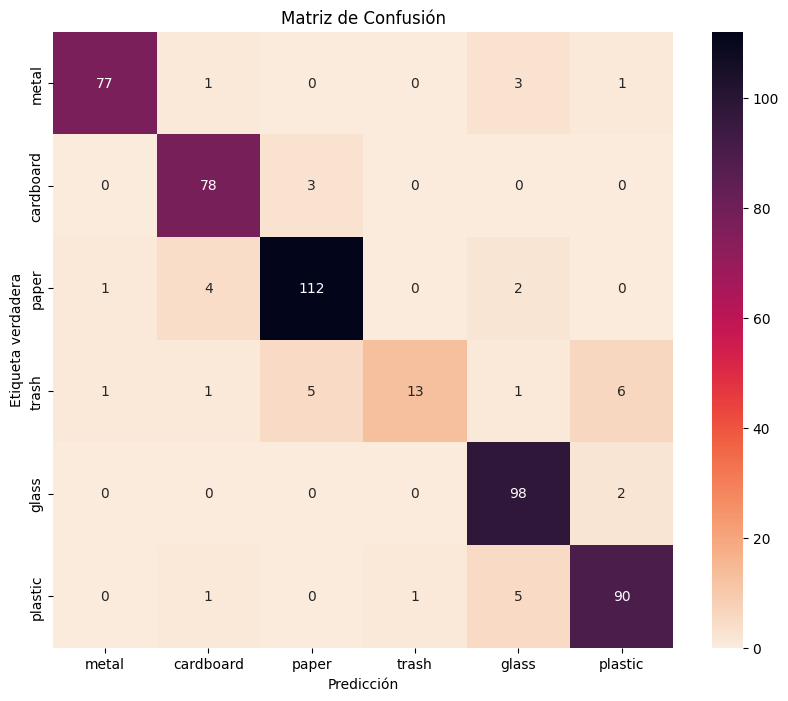


Reporte de Clasificación:
              precision    recall  f1-score   support

       metal       0.97      0.94      0.96        82
   cardboard       0.92      0.96      0.94        81
       paper       0.93      0.94      0.94       119
       trash       0.93      0.48      0.63        27
       glass       0.90      0.98      0.94       100
     plastic       0.91      0.93      0.92        97

    accuracy                           0.92       506
   macro avg       0.93      0.87      0.89       506
weighted avg       0.93      0.92      0.92       506


ROC AUC Score: 0.9947


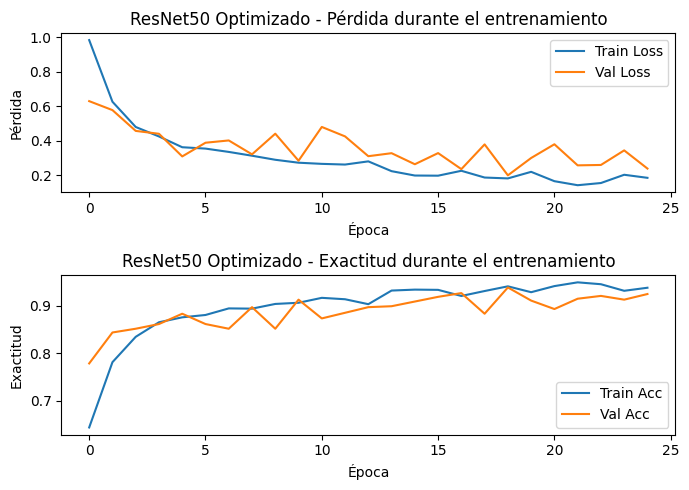

In [ ]:
# Se obtienen los mejores parámetros
best_params = study.best_params

# DataLoaders con el mejor batch_size
train_loader_final = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=2)
val_loader_final = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=2)

# Modelo final
model_final = create_resnet_model(
    num_classes=num_classes,
    freeze_features=False,
    dropout_rate=best_params['dropout_rate']
).to(device)

# Configuración de optimizador
if best_params['optimizer'] == 'Adam':
    optimizer_final = Adam(
        model_final.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
else:
    optimizer_final = SGD(
        model_final.parameters(),
        lr=best_params['lr'],
        momentum=best_params.get('momentum', 0.9),
        weight_decay=best_params['weight_decay']
    )

# Configuración de scheduler
if best_params['scheduler'] == 'ReduceLROnPlateau':
    scheduler_final = ReduceLROnPlateau(optimizer_final, mode='max', patience=3)
elif best_params['scheduler'] == 'CosineAnnealing':
    scheduler_final = CosineAnnealingLR(optimizer_final, T_max=best_params.get('T_max', 10))
else:
    scheduler_final = None

# Entrenamiento completo
history_final = train_model(
    model_final,
    criterion,
    optimizer_final,
    scheduler_final,
    num_epochs=25,
    model_name='resnet_optimized'
)

# Evaluación final
print("\nEvaluación del modelo optimizado:")
_, _, _ = evaluate_model(model_final, val_loader_final, categories)
plot_training_history(history_final, "ResNet50 Optimizado")


Análisis de los Resultados de la Optimización

In [ ]:
# Visualización de la optimización
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)
optuna.visualization.plot_parallel_coordinate(study)